<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/example%20FL%20Federated%20Model%20-%20MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

hint: install FLWR and restart session

In [2]:
!pip install flwr --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.0/754.0 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.5/323.5 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 113.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 5.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 44.0.3 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.33.5 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.33.5 whic

In [1]:
import warnings
import logging

warnings.filterwarnings("ignore", category=DeprecationWarning, module="flwr")
logging.getLogger("flwr").setLevel(logging.ERROR)
logging.getLogger("flower").setLevel(logging.ERROR)
logging.getLogger("absl").setLevel(logging.ERROR)
logging.getLogger("grpc").setLevel(logging.ERROR)

from sklearn.model_selection import train_test_split
import tensorflow as tf
import threading
import time
import flwr as fl
import numpy as np
from typing import Dict, Tuple, List, Optional
import matplotlib.pyplot as plt

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
final_federated_weights = None
server_round_history = []
centralized_model_accuracy = None

(x_train_, y_train_), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def load_data(partition_id: int, num_partitions: int = 5):
    x_train, x_val, y_train, y_val = train_test_split(x_train_, y_train_, test_size=0.2)

    x_train = x_train.astype("float32") / 255.0
    x_val = x_val.astype("float32") / 255.0

    x_train = np.expand_dims(x_train, -1)
    x_val = np.expand_dims(x_val, -1)

    partition_size = len(x_train) // num_partitions
    start_idx = partition_id * partition_size
    end_idx = start_idx + partition_size

    x_train_part = x_train[start_idx:end_idx]
    y_train_part = y_train[start_idx:end_idx]

    val_partition_size = len(x_val) // num_partitions
    val_start_idx = partition_id * val_partition_size
    val_end_idx = val_start_idx + val_partition_size

    x_val_part = x_val[val_start_idx:val_end_idx]
    y_val_part = y_val[val_start_idx:val_end_idx]

    return x_train_part, y_train_part, x_val_part, y_val_part

num_clients = 5
client_data = {}

for i in range(num_clients):
    client_data[i] = load_data(i, num_clients)
    print(f"Клиент {i}: {len(client_data[i][0])} тренировочных объектов, {len(client_data[i][2])} валидационных объектов")

Клиент 0: 9600 тренировочных объектов, 2400 валидационных объектов
Клиент 1: 9600 тренировочных объектов, 2400 валидационных объектов
Клиент 2: 9600 тренировочных объектов, 2400 валидационных объектов
Клиент 3: 9600 тренировочных объектов, 2400 валидационных объектов
Клиент 4: 9600 тренировочных объектов, 2400 валидационных объектов


In [4]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

print("Архитектура модели:")
model = create_model()
model.summary()

Архитектура модели:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
class MnistClient(fl.client.NumPyClient):
    def __init__(self, client_id: int):
        self.client_id = client_id
        self.model = create_model()
        self.x_train, self.y_train, self.x_test, self.y_test = client_data[client_id]
        self.training_history = []

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        try:
            self.model.set_weights(parameters)

            epochs = config.get("local_epochs", 1)
            batch_size = config.get("batch_size", 32)

            print(f"Клиент {self.client_id}: обучение")

            history = self.model.fit(
                self.x_train,
                self.y_train,
                epochs=epochs,
                batch_size=batch_size,
                verbose=0
            )

            accuracy = history.history['accuracy'][-1]
            print(f"Клиент {self.client_id}: точность: {accuracy:.4f}")

            return self.model.get_weights(), len(self.x_train), {
                "client_id": self.client_id,
                "accuracy": accuracy
            }
        except Exception as e:
            print(f"Клиент {self.client_id}: ошибка в fit - {e}")
            return parameters, 0, {"client_id": self.client_id, "accuracy": 0.0}

    def evaluate(self, parameters, config):
        try:
            self.model.set_weights(parameters)
            loss, accuracy = self.model.evaluate(self.x_test, self.y_test, verbose=0)

            print(f"Клиент {self.client_id}: тестовая точность: {accuracy:.4f}")

            return float(loss), len(self.x_test), {"accuracy": float(accuracy)}
        except Exception as e:
            print(f"Клиент {self.client_id}: ошибка в evaluate - {e}")
            return float(10.0), len(self.x_test), {"accuracy": 0.0}

In [6]:
class WeightSavingFedAvg(fl.server.strategy.FedAvg):
    def aggregate_fit(self, server_round, results, failures):
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            global final_federated_weights
            final_federated_weights = fl.common.parameters_to_ndarrays(aggregated_parameters)

            global server_round_history
            round_info = {
                'round': server_round,
                'weights': final_federated_weights,
                'metrics': aggregated_metrics,
                'clients_processed': len(results),
                'failures': len(failures)
            }
            server_round_history.append(round_info)

            print(f"Сервер: сохранены усредненные веса раунда {server_round}")
            print(f"Успешных клиентов: {len(results)}, Ошибок: {len(failures)}")
            if aggregated_metrics:
                print(f"Метрики: {aggregated_metrics}")

        return aggregated_parameters, aggregated_metrics

In [7]:
def fit_config(server_round: int):
    return {
        "local_epochs": 1,
        "batch_size": 32,
    }

def evaluate_config(server_round: int):
    return {"batch_size": 32}

def weighted_average(metrics: List[Tuple[int, Dict]]):
    if metrics and "accuracy" in metrics[0][1]:
        accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
        examples = [num_examples for num_examples, _ in metrics]
        accuracy = sum(accuracies) / sum(examples)
        print(f"Средняя точность клиентов: {accuracy:.4f}")
        return {"accuracy": accuracy}
    return {}

In [8]:
def train_centralized_model():
    centralized_model = create_model()

    print("Обучение централизованной модели")
    history = centralized_model.fit(
        x_train_, y_train_,
        epochs=3,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    test_loss, test_accuracy = centralized_model.evaluate(x_test, y_test, verbose=0)

    print(f"Централизованная модель:")
    print(f"Точность: {test_accuracy:.4f}")
    print(f"Ошибка: {test_loss:.4f}")

    global centralized_model_accuracy
    centralized_model_accuracy = test_accuracy

    return test_accuracy, centralized_model

In [9]:
def start_complete_federated_system(port=8085):
    global final_federated_weights, server_round_history, centralized_model_accuracy
    final_federated_weights = None
    server_round_history = []
    centralized_model_accuracy = None

    centralized_accuracy, _ = train_centralized_model()

    strategy = WeightSavingFedAvg(
        fraction_fit=1.0,
        fraction_evaluate=0.5,
        min_fit_clients=2,
        min_evaluate_clients=1,
        min_available_clients=2,
        evaluate_metrics_aggregation_fn=weighted_average,
        on_fit_config_fn=fit_config,
        on_evaluate_config_fn=evaluate_config,
    )

    def run_client(client_id):
        try:
            print(f"Клиент {client_id}: подключение к серверу")
            client = MnistClient(client_id)
            fl.client.start_numpy_client(
                server_address=f"127.0.0.1:{port}",
                client=client
            )
            print(f"Клиент {client_id}: завершил работу")
        except Exception as e:
            print(f"Клиент {client_id}: ошибка подключения - {e}")

    def start_all_clients():
        time.sleep(3)

        client_threads = []
        for i in range(num_clients):
            thread = threading.Thread(
                target=run_client,
                args=(i,),
                daemon=True
            )
            client_threads.append(thread)
            thread.start()
            print(f"Клиент {i}: запущен")
            time.sleep(1)

    clients_thread = threading.Thread(target=start_all_clients, daemon=True)
    clients_thread.start()

    try:
        fl.server.start_server(
            server_address=f"0.0.0.0:{port}",
            config=fl.server.ServerConfig(num_rounds=3),
            strategy=strategy
        )

        print("\nФедеративное обучение завершено")

        if final_federated_weights is not None:
            test_accuracy = evaluate_federated_model()

            compare_models(test_accuracy, centralized_accuracy)

            return test_accuracy
        else:
            print("Веса не были сохранены")
            return None

    except Exception as e:
        print(f"\nОшибка сервера: {e}")
        return None

In [10]:
def evaluate_federated_model():
    if final_federated_weights is None:
        print("Агрегированные веса не сохранены.")
        return None

    federated_model = create_model()
    federated_model.set_weights(final_federated_weights)

    print("Модель инициализирована агрегированными весами")

    print("Тестирование федеративной модели...")
    test_loss, test_accuracy = federated_model.evaluate(x_test, y_test, verbose=0)

    print(f"Федеративная модель:")
    print(f"Точность: {test_accuracy:.4f}")
    print(f"Ошибка: {test_loss:.4f}")

    if server_round_history:
        print(f"\nИстория раундов обучения:")
        for round_info in server_round_history:
            print(f"Раунд {round_info['round']}: {round_info['clients_processed']} клиентов, {round_info['failures']} ошибок")

    return test_accuracy

In [11]:
def compare_models(federated_accuracy, centralized_accuracy):
    if federated_accuracy is None or centralized_accuracy is None:
        print("Недостаточно данных для сравнения")
        return

    print("Централизованная модель:")
    print(f"Точность: {centralized_accuracy:.4f}")

    print("Федеративная модель:")
    print(f"Точность: {federated_accuracy:.4f}")

    difference = federated_accuracy - centralized_accuracy
    difference_percent = difference * 100

    print(f"\nРазница:")
    print(f"Абсолютная: {difference:+.4f}")
    print(f"Относительная: {difference_percent:+.2f}%")

    if difference > 0:
        print("Федеративное обучение показало лучший результат!")
    elif difference < 0:
        print("Централизованное обучение показало лучший результат")
    else:
        print("Результаты одинаковые")

    models = ['Централизованная', 'Федеративная']
    accuracies = [centralized_accuracy, federated_accuracy]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=['skyblue', 'lightcoral'], alpha=0.7)
    plt.ylabel('Точность')
    plt.title('Сравнение централизованного и федеративного обучения')
    plt.ylim(0, 1)

    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{accuracy:.4f}', ha='center', va='bottom', fontweight='bold')

    plt.axhline(y=centralized_accuracy, color='red', linestyle='--', alpha=0.5, label='Централизованная')
    plt.axhline(y=federated_accuracy, color='blue', linestyle='--', alpha=0.5, label='Федеративная')

    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Обучение централизованной модели
Epoch 1/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7279 - loss: 2.0638 - val_accuracy: 0.9738 - val_loss: 0.0917
Epoch 2/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9502 - loss: 0.1726 - val_accuracy: 0.9823 - val_loss: 0.0648
Epoch 3/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9627 - loss: 0.1285 - val_accuracy: 0.9838 - val_loss: 0.0606


	Instead, use the `flower-superlink` CLI command to start a SuperLink as shown below:

		$ flower-superlink --insecure

	To view usage and all available options, run:

		$ flower-superlink --help

	Using `start_server()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flower-superlink` CLI command to start a SuperLink as shown below:

		$ flower-superlink --insecure

	To view usage and all available options, run:

		$ flower-superlink --help

	Using `start_server()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower server, config: num_rounds=3, no round_timeout
INFO:flwr:Starting Flower server, config: num_rounds=3, no round_timeout
INFO :      Flower ECE: gRPC server running (3 rounds), SSL is disabled
INFO:flwr:Flower ECE: gRPC server running (3 rounds), SSL is dis

Централизованная модель:
Точность: 0.9847
Ошибка: 0.0540


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
	Instead, use `flwr.client.start_client()` by ensuring you first call the `.to_client()` method as shown below: 
	flwr.client.start_client(
		server_address='<IP>:<PORT>',
		client=FlowerClient().to_client(), # <-- where FlowerClient is of type flwr.client.NumPyClient object
	)
	Using `start_numpy_client()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use `flwr.client.start_client()` by ensuring you first call the `.to_client()` method as shown below: 
	flwr.client.start_client(
		server_address='<IP>:<PORT>',
		client=FlowerClient().to_client(), 

Клиент 0: подключение к серверу
Клиент 0: запущен


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
	Instead, use `flwr.client.start_client()` by ensuring you first call the `.to_client()` method as shown below: 
	flwr.client.start_client(
		server_address='<IP>:<PORT>',
		client=FlowerClient().to_client(), # <-- where FlowerClient is of type flwr.client.NumPyClient object
	)
	Using `start_numpy_client()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use `flwr.client.start_client()` by ensuring you first call the `.to_client()` method as shown below: 
	flwr.client.start_client(
		server_address='<IP>:<PORT>',
		client=FlowerClient().to_client(), 

Клиент 1: подключение к серверу
Клиент 1: запущен
Клиент 1: обучение
Клиент 0: обучение


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
	Instead, use `flwr.client.start_client()` by ensuring you first call the `.to_client()` method as shown below: 
	flwr.client.start_client(
		server_address='<IP>:<PORT>',
		client=FlowerClient().to_client(), # <-- where FlowerClient is of type flwr.client.NumPyClient object
	)
	Using `start_numpy_client()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use `flwr.client.start_client()` by ensuring you first call the `.to_client()` method as shown below: 
	flwr.client.start_client(
		server_address='<IP>:<PORT>',
		client=FlowerClient().to_client(), 

Клиент 2: подключение к серверу
Клиент 2: запущен


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
	Instead, use `flwr.client.start_client()` by ensuring you first call the `.to_client()` method as shown below: 
	flwr.client.start_client(
		server_address='<IP>:<PORT>',
		client=FlowerClient().to_client(), # <-- where FlowerClient is of type flwr.client.NumPyClient object
	)
	Using `start_numpy_client()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use `flwr.client.start_client()` by ensuring you first call the `.to_client()` method as shown below: 
	flwr.client.start_client(
		server_address='<IP>:<PORT>',
		client=FlowerClient().to_client(), 

Клиент 3: подключение к серверу
Клиент 3: запущен
Клиент 4: подключение к серверуКлиент 4: запущен



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
	Instead, use `flwr.client.start_client()` by ensuring you first call the `.to_client()` method as shown below: 
	flwr.client.start_client(
		server_address='<IP>:<PORT>',
		client=FlowerClient().to_client(), # <-- where FlowerClient is of type flwr.client.NumPyClient object
	)
	Using `start_numpy_client()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use `flwr.client.start_client()` by ensuring you first call the `.to_client()` method as shown below: 
	flwr.client.start_client(
		server_address='<IP>:<PORT>',
		client=FlowerClient().to_client(), 

Клиент 1: точность: 0.8179
Клиент 0: точность: 0.8138
Сервер: сохранены усредненные веса раунда 1
Успешных клиентов: 2, Ошибок: 0


INFO :      Sent reply
INFO:flwr:Sent reply
INFO :      Sent reply
INFO:flwr:Sent reply
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 2]
INFO:flwr:[ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)
INFO :      
INFO:flwr:
INFO :      
INFO :      
INFO :      
INFO:flwr:
INFO :      Received: train message a692c00f-5176-407f-9754-c826e74c7a71
INFO :      Received: train message e857162f-5cbf-43fe-81a3-4b800cdb43e4
INFO:flwr:
INFO :      
INFO:flwr:
INFO :      Received: train message ef721003-2453-4e94-8637-358130941c2d
INFO :      Received: train message 86ba0efa-a0e1-4f4c-91b0-980c5ac1aca7
INFO:flwr:Received: train message a692c00f-5176-407f-9754-c826e74c7a71


Клиент 2: тестовая точность: 0.9663
Клиент 4: тестовая точность: 0.9613
Средняя точность клиентов: 0.9638


INFO:flwr:Received: train message e857162f-5cbf-43fe-81a3-4b800cdb43e4
INFO:flwr:
INFO :      Received: train message c1529782-63e1-4650-882f-6f11382ddfc4
INFO:flwr:Received: train message ef721003-2453-4e94-8637-358130941c2d
INFO:flwr:Received: train message 86ba0efa-a0e1-4f4c-91b0-980c5ac1aca7
INFO:flwr:Received: train message c1529782-63e1-4650-882f-6f11382ddfc4


Клиент 0: обучение
Клиент 1: обучение
Клиент 2: обучение
Клиент 4: обучение
Клиент 3: обучение


INFO :      Sent reply
INFO:flwr:Sent reply
INFO :      Sent reply
INFO:flwr:Sent reply


Клиент 0: точность: 0.9439
Клиент 1: точность: 0.9447


INFO :      Sent reply
INFO:flwr:Sent reply
INFO :      Sent reply
INFO:flwr:Sent reply


Клиент 4: точность: 0.9427
Клиент 2: точность: 0.9436


INFO :      Sent reply
INFO:flwr:Sent reply
INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)
INFO :      
INFO:flwr:
INFO :      
INFO:flwr:
INFO :      Received: evaluate message dacadd95-897d-438a-a259-bafb396441ad
INFO:flwr:Received: evaluate message dacadd95-897d-438a-a259-bafb396441ad
INFO :      Received: evaluate message 2c107e69-d9b4-4ee1-9c44-03553beddaa6
INFO:flwr:Received: evaluate message 2c107e69-d9b4-4ee1-9c44-03553beddaa6


Клиент 3: точность: 0.9420
Сервер: сохранены усредненные веса раунда 2
Успешных клиентов: 5, Ошибок: 0


INFO :      Sent reply
INFO:flwr:Sent reply


Клиент 2: тестовая точность: 0.9783


INFO :      Sent reply
INFO:flwr:Sent reply
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 3]
INFO:flwr:[ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)
INFO :      
INFO:flwr:
INFO :      
INFO:flwr:
INFO :      
INFO:flwr:
INFO :      
INFO:flwr:
INFO :      Received: train message 98cac44d-630b-43e9-ba5a-b5a7861f05b0
INFO:flwr:Received: train message 98cac44d-630b-43e9-ba5a-b5a7861f05b0
INFO :      Received: train message fa93a0c8-8e23-4163-9994-d14ca657780d
INFO :      
INFO :      Received: train message 4129a622-efff-4e61-ad61-f0db2d9d34bd
INFO:flwr:Received: train message fa93a0c8-8e23-4163-9994-d14ca657780d
INFO:flwr:
INFO :      Received: train message 8d8a99ce-76c9-4548-9fb9-1fce8846da6b
INFO :      Received: train message b5a18282-8459-4fca-8aa3-d414970977ce
INFO:

Клиент 3: тестовая точность: 0.9746
Средняя точность клиентов: 0.9765
Клиент 3: обучение
Клиент 2: обучение
Клиент 0: обучение
Клиент 1: обучение
Клиент 4: обучение


INFO :      Sent reply
INFO:flwr:Sent reply
INFO :      Sent reply
INFO:flwr:Sent reply
INFO :      Sent reply
INFO:flwr:Sent reply
INFO :      Sent reply
INFO:flwr:Sent reply
INFO :      Sent reply
INFO:flwr:Sent reply
INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)
INFO :      
INFO:flwr:
INFO :      Received: evaluate message af68705f-eba0-428e-b140-56a310010a58
INFO:flwr:Received: evaluate message af68705f-eba0-428e-b140-56a310010a58
INFO :      
INFO:flwr:
INFO :      Received: evaluate message 91893535-4a15-4052-b9ed-0e41e1e7ddb5
INFO:flwr:Received: evaluate message 91893535-4a15-4052-b9ed-0e41e1e7ddb5


Клиент 3: точность: 0.9639
Клиент 4: точность: 0.9610
Клиент 1: точность: 0.9655
Клиент 0: точность: 0.9611
Клиент 2: точность: 0.9617
Сервер: сохранены усредненные веса раунда 3
Успешных клиентов: 5, Ошибок: 0


INFO :      Sent reply
INFO:flwr:Sent reply


Клиент 2: тестовая точность: 0.9825


INFO :      Sent reply
INFO:flwr:Sent reply
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [SUMMARY]
INFO:flwr:[SUMMARY]
INFO :      Run finished 3 round(s) in 27.85s
INFO:flwr:Run finished 3 round(s) in 27.85s
INFO :      	History (loss, distributed):
INFO:flwr:	History (loss, distributed):
INFO :      		round 1: 0.1488306224346161
INFO:flwr:		round 1: 0.1488306224346161
INFO :      		round 2: 0.07860312983393669
INFO:flwr:		round 2: 0.07860312983393669
INFO :      		round 3: 0.06399221532046795
INFO:flwr:		round 3: 0.06399221532046795
INFO :      	History (metrics, distributed, evaluate):
INFO:flwr:	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.9637500047683716),
INFO:flwr:	{'accuracy': [(1, 0.9637500047683716),
INFO :      	              (2, 0.976458340883255),
INFO:flwr:	              (2, 0.976458340883255),
INFO :      	              (

Клиент 1: тестовая точность: 0.9808
Средняя точность клиентов: 0.9817

Федеративное обучение завершено
Клиент 2: завершил работу
Клиент 0: завершил работу
Клиент 4: завершил работу
Клиент 1: завершил работу
Клиент 3: завершил работу
Модель инициализирована агрегированными весами
Тестирование федеративной модели...
Федеративная модель:
Точность: 0.9820
Ошибка: 8.0422

История раундов обучения:
Раунд 1: 2 клиентов, 0 ошибок
Раунд 2: 5 клиентов, 0 ошибок
Раунд 3: 5 клиентов, 0 ошибок
Централизованная модель:
Точность: 0.9847
Федеративная модель:
Точность: 0.9820

Разница:
Абсолютная: -0.0027
Относительная: -0.27%
Централизованное обучение показало лучший результат


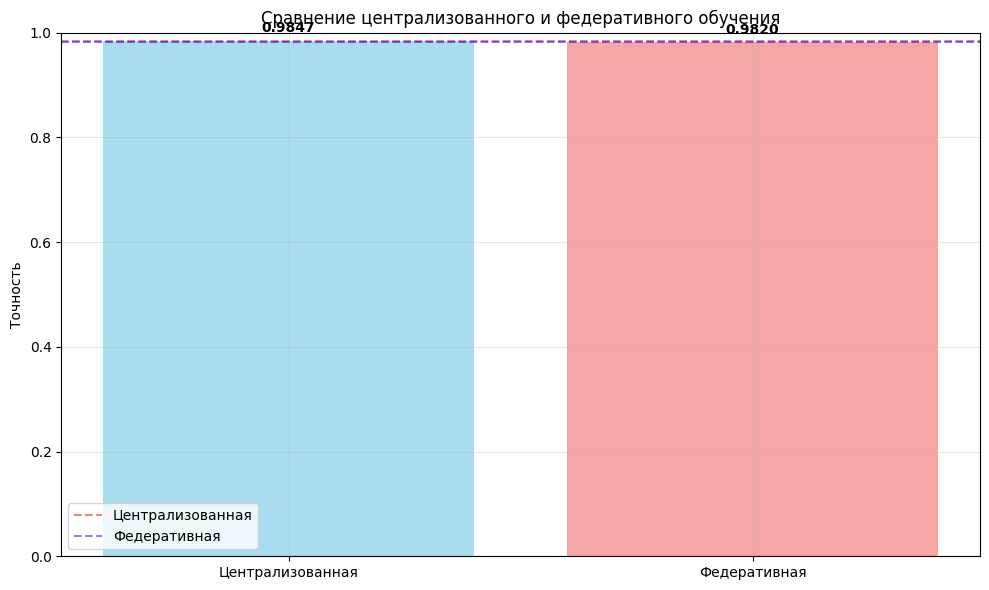

In [12]:
def visualize_predictions_comparison(federated_model, centralized_model):
    sample_indices = np.random.choice(len(x_test), 8, replace=False)

    fed_predictions = federated_model.predict(x_test[sample_indices], verbose=0)
    fed_classes = np.argmax(fed_predictions, axis=1)
    fed_confidences = np.max(fed_predictions, axis=1)

    cent_predictions = centralized_model.predict(x_test[sample_indices], verbose=0)
    cent_classes = np.argmax(cent_predictions, axis=1)
    cent_confidences = np.max(cent_predictions, axis=1)

    fig, axes = plt.subplots(4, 4, figsize=(15, 12))

    for i, idx in enumerate(sample_indices):
        row = i * 2

        ax1 = axes[row, 0]
        ax1.imshow(x_test[idx].squeeze(), cmap='gray')
        fed_correct = fed_classes[i] == y_test[idx]
        color1 = 'green' if fed_correct else 'red'
        ax1.set_title(f'Федеративная\nPred: {fed_classes[i]} (conf: {fed_confidences[i]:.2f})',
                     color=color1, fontsize=10)
        ax1.axis('off')

        ax2 = axes[row, 1]
        ax2.imshow(x_test[idx].squeeze(), cmap='gray')
        cent_correct = cent_classes[i] == y_test[idx]
        color2 = 'green' if cent_correct else 'red'
        ax2.set_title(f'Централизованная\nPred: {cent_classes[i]} (conf: {cent_confidences[i]:.2f})',
                     color=color2, fontsize=10)
        ax2.axis('off')

        axes[row+1, 0].axis('off')
        axes[row+1, 1].axis('off')
        axes[row+1, 0].text(0.5, 0.5, f'True: {y_test[idx]}',
                           ha='center', va='center', fontsize=12, fontweight='bold')

    plt.suptitle('Сравнение предсказаний моделей', fontsize=16)
    plt.tight_layout()
    plt.show()

test_accuracy = start_complete_federated_system(8085)